In [ ]:
# Connect Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# All Imports
!pip install np_utils
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.models import Model

import tensorflow as tf
from tensorflow.python.tools import freeze_graph, optimize_for_inference_lib

import numpy as np

np.random.seed(123)
import pandas as pd
import gzip
import _pickle as cPickle
import os
import matplotlib.pyplot as plt
from collections import Counter
from __future__ import absolute_import
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.neighbors import KDTree
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

     |████████████████████████████████| 61 kB 3.2 MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57131 sha256=bf803d89ca7b370c9582bdaa2188d9e62f7ff1b85c751eda72e14e0391f37d4e
  Stored in directory: /root/.cache/pip/wheels/8c/4e/ef/095c24693723c329f4cdc1079861cdbb2487d4b41b2496a4e7
Successfully built np-utils


In [ ]:
def get_model():
    vgg_model = keras.applications.VGG16(include_top=True, weights='imagenet')
    vgg_model.layers.pop()
    vgg_model.layers.pop()

    inp = vgg_model.input
    out = vgg_model.layers[-1].output

    model = Model(inp, out)
    return model

def get_features(model, cropped_image):
    x = image.img_to_array(cropped_image)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    features = model.predict(x)
    return features

In [ ]:
# Initialize Parameters
BATCH_SIZE = 128
EPOCH = 300

# Paths
WORD2VECPATH    = "/content/drive/MyDrive/Machine Learning/Zero Shot Learning/NTECH/CIFAR/ZSL/class_vec.npy"
DATAPATH        = "/content/drive/MyDrive/Machine Learning/Zero Shot Learning/NTECH/CIFAR/ZSL/zeroshot_data.pkl"
MODELPATH       = "/content/drive/MyDrive/Machine Learning/Zero Shot Learning/NTECH/CIFAR/ZSL/"
# TRAINCLASSESPATH  = "/content/drive/MyDrive/Machine Learning/Zero Shot Learning/scene/train_classes.txt"
# ZSLCLASSESPATH  = "/content/drive/MyDrive/Machine Learning/Zero Shot Learning/scene/zsl_classes.txt"

In [ ]:
# Utility to save and load trained model
def load_keras_model(model_path):
    with open(model_path +"model.json", 'r') as json_file:
        loaded_model_json = json_file.read()

    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_path+"model.h5")
    return loaded_model

def save_keras_model(model, model_path):
    """save Keras model and its weights"""
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    model_json = model.to_json()
    with open(model_path + "model.json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(model_path + "model.h5")
    print("-> zsl model is saved.")
    return

In [ ]:
# Load the CIFAR data
def load_data():
    """read data, create datasets"""
    # READ DATA
    data = pd.read_pickle(DATAPATH)
    # ONE-HOT-ENCODE DATA
    label_encoder   = LabelEncoder()
    label_encoder.fit(train_classes)

    zsl_label_encoder   = LabelEncoder()
    zsl_label_encoder.fit(zsl_classes)

    # Prepare training and validation data
    training_data = []
    training_data_cls = []
    for i in range(len(data)):
      lock = False
      t_cls = []
      for cls in train_classes:
        if data['class'][i]==cls:
          if lock == False:
            training_data.append(data.loc[i][:-1])
            lock = True
          t_cls.append(cls)
      training_data_cls.append(t_cls.copy())
    training_data_cls = list(filter(None, training_data_cls))
    valid_data_cls = training_data_cls[int(len(training_data_cls)*0.9):]

    # Prepare Unseen / ZSL data
    zero_shot_data = []
    zero_shot_data_cls = []
    for i in range(len(data)):
      lock = False
      t_cls = []
      for cls in zsl_classes:
        if data['class'][i]==cls:
          if lock == False:
            zero_shot_data.append(data.loc[i][:-1])
            lock = True
          t_cls.append(cls)
      zero_shot_data_cls.append(t_cls.copy())
    zero_shot_data_cls = list(filter(None, zero_shot_data_cls))
      

    # SHUFFLE TRAINING DATA
    # np.random.shuffle(training_data)

    ### SPLIT DATA FOR TRAINING
    train_size  = len(training_data)
  
    # 90-10 split
    train_data = training_data[:int(len(training_data)*0.9)]
    valid_data = training_data[int(len(training_data)*0.9):]
    
    # Transform 'class' to one hot encoded
    train_data = [(train_data[i], tf.keras.utils.to_categorical(label_encoder.transform(training_data_cls[i]), num_classes=len(train_classes)))for i in range(len(train_data))]
    valid_data = [(valid_data[i], tf.keras.utils.to_categorical(label_encoder.transform(valid_data_cls[i]), num_classes=len(train_classes)))for i in range(len(valid_data))]
    
    # FORM X_TRAIN AND Y_TRAIN
    x_train, y_train    = zip(*train_data)
    x_train, y_train    = np.squeeze(np.asarray(x_train)), np.squeeze(np.asarray(y_train))
    # L2 NORMALIZE X_TRAIN
    x_train = normalize(x_train, norm='l2')

    # FORM X_VALID AND Y_VALID
    x_valid, y_valid = zip(*valid_data)
    x_valid, y_valid = np.squeeze(np.asarray(x_valid)), np.squeeze(np.asarray(y_valid))
    # L2 NORMALIZE X_VALID
    x_valid = normalize(x_valid, norm='l2')


    # FORM X_ZSL AND Y_ZSL
    zero_shot_data = [(zero_shot_data[i], tf.keras.utils.to_categorical(zsl_label_encoder.transform(zero_shot_data_cls[i]), num_classes=len(zsl_classes)))for i in range(len(zero_shot_data))]
    
    x_zsl,y_zsl = zip(*zero_shot_data)
    x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)), np.squeeze(np.asarray(y_zsl))
    # L2 NORMALIZE X_ZSL
    x_zsl = normalize(x_zsl, norm='l2')

    print("-> data loading is completed.")
    return (x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl)


In [ ]:
# Map index to class names
'''
Content of the CIFAR 100 Dataset
'''
idx2label={
0: 'apple',
1: 'fish',
2: 'baby',
3: 'bear',
4: 'beaver',
5: 'bed',
6: 'bee',
7: 'beetle',
8: 'bicycle',
9: 'bottle',
10: 'bowl',
11: 'boy',
12: 'bridge',
13: 'bus',
14: 'butterfly',
15: 'camel',
16: 'can',
17: 'castle',
18: 'caterpillar',
19: 'cattle',
20: 'chair',
21: 'chimpanzee',
22: 'clock',
23: 'cloud',
24: 'cockroach',
25: 'couch',
26: 'crab',
27: 'crocodile',
28: 'cup',
29: 'dinosaur',
30: 'dolphin',
31: 'elephant',
32: 'flatfish',
33: 'forest',
34: 'fox',
35: 'girl',
36: 'hamster',
37: 'house',
38: 'kangaroo',
39: 'keyboard',
40: 'lamp',
41: 'mower',
42: 'leopard',
43: 'lion',
44: 'lizard',
45: 'lobster',
46: 'man',
47: 'maple',
48: 'motorcycle',
49: 'mountain',
50: 'mouse',
51: 'mushroom',
52: 'oak',
53: 'orange',
54: 'orchid',
55: 'otter',
56: 'palm',
57: 'pear',
58: 'truck',
59: 'pine',
60: 'plain',
61: 'plate',
62: 'poppy',
63: 'porcupine',
64: 'possum',
65: 'rabbit',
66: 'raccoon',
67: 'ray',
68: 'road',
69: 'rocket',
70: 'rose',
71: 'sea',
72: 'seal',
73: 'shark',
74: 'shrew',
75: 'skunk',
76: 'skyscraper',
77: 'snail',
78: 'snake',
79: 'spider',
80: 'squirrel',
81: 'streetcar',
82: 'sunflower',
83: 'pepper',
84: 'table',
85: 'tank',
86: 'telephone',
87: 'television',
88: 'tiger',
89: 'tractor',
90: 'train',
91: 'trout',
92: 'tulip',
93: 'turtle',
94: 'wardrobe',
95: 'whale',
96: 'tree',
97: 'wolf',
98: 'woman',
99: 'worm'
}

In [ ]:
# Utility to put the word2vec in the last layer
def custom_kernel_init(shape,dtype=None):
    class_vectors       = np.load(WORD2VECPATH, allow_pickle=True)
    training_vectors    = sorted([(label, vec) for (label, vec) in class_vectors if label in train_classes], key=lambda x: x[0])
    classnames, vectors = zip(*training_vectors)
    vectors             = np.asarray(vectors, dtype=np.float)
    vectors             = vectors.T
    return vectors

# Construct a model (sequential)
def  build_model(NUM_FEATURES):
    model = Sequential()
    model.add(Dense(1024, input_shape=(NUM_FEATURES,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_FEATURES, activation='relu'))
    model.add(Dense(NUM_ATTR, activation='relu'))
    model.add(Dense(NUM_CLASS, activation='softmax', trainable=False, kernel_initializer=(custom_kernel_init)))

    print(model.summary())
    print("-> model building is completed.")
    return model

In [ ]:
# Train function
def train_model(model, train_data, valid_data):
    x_train, y_train = train_data
    x_valid, y_valid = valid_data
    adam = Adam(lr=5e-5)
    model.compile(loss      = 'categorical_crossentropy',
                  optimizer = adam,
                  metrics   = ['categorical_accuracy', 'top_k_categorical_accuracy'])
   
    # Convert to tensors
    x_train = tf.convert_to_tensor(x_train)
    x_valid = tf.convert_to_tensor(x_valid)
    y_train = tf.convert_to_tensor(y_train)
    y_valid = tf.convert_to_tensor(y_valid)
    
    print(x_train.shape,x_valid.shape)
    print(y_train.shape,y_valid.shape)
    history = model.fit(x_train, y_train,
                        validation_data = (x_valid, y_valid),
                        verbose         = 2,
                        epochs          = EPOCH,
                        batch_size      = BATCH_SIZE,
                        shuffle         = True)

    print("model training is completed.")
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return history

-> data loading is completed.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3072)              1575936   
                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/300
317/317 - 38s - loss: 4.3636 - categorical_accuracy: 0.0306 - top_k_categorical_accuracy: 0.1269 - val_loss: 4.4021 - val_categorical_accuracy: 0.0604 - val_top_k_categorical_accuracy: 0.2196 - 38s/epoch - 120ms/step
Epoch 2/300
317/317 - 37s - loss: 4.1211 - categorical_accuracy: 0.0585 - top_k_categorical_accuracy: 0.2165 - val_loss: 4.0411 - val_categorical_accuracy: 0.0949 - val_top_k_categorical_accuracy: 0.2778 - 37s/epoch - 118ms/step
Epoch 3/300
317/317 - 39s - loss: 3.9990 - categorical_accuracy: 0.0758 - top_k_categorical_accuracy: 0.2620 - val_loss: 3.8257 - val_categorical_accuracy: 0.1104 - val_top_k_categorical_accuracy: 0.3156 - 39s/epoch - 123ms/step
Epoch 4/300
317/317 - 37s - loss: 3.9106 - categorical_accuracy: 0.0913 - top_k_categorical_accuracy: 0.2896 - val_loss: 3.7385 - val_categorical_accuracy: 0.1249 - val_top_k_categorical_accuracy: 0.3382 - 37s/epoch - 118ms/step
Epoch 5/300
317/317 - 38s - loss: 3.8518 - categorical_accuracy: 0.1006 - top_k_cate

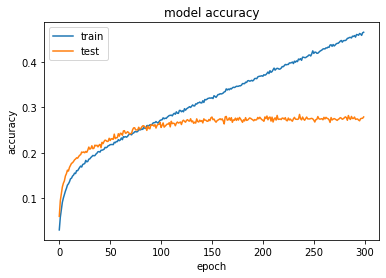

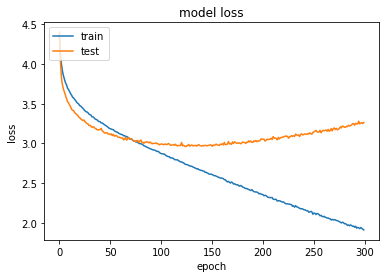

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3072)              1575936   
                                                        

In [ ]:
def main():
    
    cutoff_cls = 10 # Before 2-> unseen, after 2 ->seen till all cls (100)
    global train_classes
    train_classes = [i for i in range(cutoff_cls,100)]
    global zsl_classes
    zsl_classes = [i for i in range(cutoff_cls)]
    # ---------------------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------------------- #
    # SET HYPERPARAMETERS

    global NUM_CLASS, NUM_ATTR, EPOCH, BATCH_SIZE
    NUM_CLASS = len(train_classes)
    NUM_ATTR = 300
    NUM_FEATURES = 3072 # data.columns[-2]  The last column is the class.

    # ---------------------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------------------- #
    # TRAINING PHASE

    (x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl) = load_data()
    model = build_model(NUM_FEATURES)
    train_model(model, (x_train, y_train), (x_valid, y_valid))
    print(model.summary())

    # ---------------------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------------------- #
    # CREATE AND SAVE ZSL MODEL

    inp         = model.input
    out         = model.layers[-2].output
    zsl_model   = Model(inp, out)
    print(zsl_model.summary())
    save_keras_model(zsl_model, model_path=MODELPATH)

if __name__ == '__main__':
    main()

In [ ]:
# Load data and model
(x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl) = load_data()
zsl_model = load_keras_model(model_path=MODELPATH)

class_vectors       = sorted(np.load(WORD2VECPATH, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames          = list(classnames)
vectors             = np.asarray(vectors, dtype=np.float)

tree        = KDTree(vectors) # Build a decision tree for prediction
pred_zsl    = zsl_model.predict(x_zsl)

-> data loading is completed.


In [ ]:
# Test model for zero shot learning (actual label found in top 5 preds, 3 preds and 1 pred)
top5, top3, top1 = 0, 0, 0
for i, pred in enumerate(pred_zsl):
  pred            = np.expand_dims(pred, axis=0)
  dist_5, index_5 = tree.query(pred, k=5)
  pred_labels     = [[classnames[index]] for index in index_5[0]]
  print("Pred labels:", pred_labels)
  true_label = [[x] for x,y in zip(zsl_classes,list(map(bool,y_zsl[i]))) if y==True]
  print("True labels:", true_label)
  
  try:
    # if true_label in pred_labels:
    top5 += [label in true_label for label in pred_labels].count(True)
    # if true_label in pred_labels[:3]:
    top3 += [label in true_label for label in pred_labels[:3]].count(True) 
    # if true_label in pred_labels[0]:
    top1 += [label in true_label for label in pred_labels[0]].count(True) 
  except:
    pass
print()
print("ZERO SHOT LEARNING SCORE")
print("-> Top-5 Accuracy: %.3f" % (top5 / float(len(x_zsl))))
print("-> Top-3 Accuracy: %.3f" % (top3 / float(len(x_zsl))))
print("-> Top-1 Accuracy: %.3f" % (top1 / float(len(x_zsl))))

Streaming output truncated to the last 5000 lines.
True labels: [[7]]
Pred labels: [[87], [16], [75], [61], [65]]
True labels: [[7]]
Pred labels: [[24], [29], [72], [50], [44]]
True labels: [[7]]
Pred labels: [[11], [46], [98], [35], [15]]
True labels: [[2]]
Pred labels: [[98], [46], [11], [35], [16]]
True labels: [[2]]
Pred labels: [[51], [53], [57], [0], [16]]
True labels: [[6]]
Pred labels: [[53], [0], [57], [61], [10]]
True labels: [[0]]
Pred labels: [[57], [59], [96], [16], [92]]
True labels: [[0]]
Pred labels: [[16], [87], [46], [84], [51]]
True labels: [[2]]
Pred labels: [[71], [60], [37], [5], [23]]
True labels: [[1]]
Pred labels: [[8], [4], [48], [19], [87]]
True labels: [[7]]
Pred labels: [[37], [38], [4], [74], [19]]
True labels: [[4]]
Pred labels: [[8], [4], [48], [3], [89]]
True labels: [[1]]
Pred labels: [[61], [57], [16], [22], [53]]
True labels: [[0]]
Pred labels: [[4], [44], [65], [80], [46]]
True labels: [[6]]
Pred labels: [[93], [16], [86], [63], [72]]
True labels: [

In [ ]:
BATCH_SIZE = 128
EPOCH = 300

# New word2vec (word vector + VGG feature)
WORD2VECPATH    = "/content/drive/MyDrive/Machine Learning/Zero Shot Learning/NTECH/CIFAR/ZSL/class_vec_new.npy"
DATAPATH        = "/content/drive/MyDrive/Machine Learning/Zero Shot Learning/NTECH/CIFAR/ZSL/zeroshot_data.pkl"
MODELPATH       = "/content/drive/MyDrive/Machine Learning/Zero Shot Learning/NTECH/CIFAR/ZSL/"


def load_keras_model(model_path):
    with open(model_path +"model.json", 'r') as json_file:
        loaded_model_json = json_file.read()

    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_path+"model_new.h5")
    return loaded_model

def save_keras_model(model, model_path):
    """save Keras model and its weights"""
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    model_json = model.to_json()
    with open(model_path + "model.json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(model_path + "model_new.h5")
    print("-> zsl model is saved.")
    return

In [ ]:
# Re-run the ZSL
def main():
    
    cutoff_cls = 10 # Before 2-> unseen, after 2 ->seen till all cls (100)
    global train_classes
    train_classes = [i for i in range(cutoff_cls,100)]
    global zsl_classes
    zsl_classes = [i for i in range(cutoff_cls)]
    # ---------------------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------------------- #
    # SET HYPERPARAMETERS

    global NUM_CLASS, NUM_ATTR, EPOCH, BATCH_SIZE
    NUM_CLASS = len(train_classes)
    NUM_ATTR = 400
    NUM_FEATURES = 3072 # data.columns[-2]  The last column is the class.

    # ---------------------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------------------- #
    # TRAINING PHASE

    (x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl) = load_data()
    model = build_model(NUM_FEATURES)
    train_model(model, (x_train, y_train), (x_valid, y_valid))
    print(model.summary())

    # ---------------------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------------------- #
    # CREATE AND SAVE ZSL MODEL

    inp         = model.input
    out         = model.layers[-2].output
    zsl_model   = Model(inp, out)
    print(zsl_model.summary())
    save_keras_model(zsl_model, model_path=MODELPATH)

if __name__ == '__main__':
    main()

-> data loading is completed.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              3146752   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3072)              1575936   
                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


317/317 - 39s - loss: 4.3431 - categorical_accuracy: 0.0328 - top_k_categorical_accuracy: 0.1360 - val_loss: 4.3943 - val_categorical_accuracy: 0.0596 - val_top_k_categorical_accuracy: 0.2104 - 39s/epoch - 124ms/step
Epoch 2/300
317/317 - 38s - loss: 4.1118 - categorical_accuracy: 0.0598 - top_k_categorical_accuracy: 0.2161 - val_loss: 4.0218 - val_categorical_accuracy: 0.0958 - val_top_k_categorical_accuracy: 0.2816 - 38s/epoch - 121ms/step
Epoch 3/300
317/317 - 38s - loss: 3.9889 - categorical_accuracy: 0.0771 - top_k_categorical_accuracy: 0.2605 - val_loss: 3.8237 - val_categorical_accuracy: 0.1144 - val_top_k_categorical_accuracy: 0.3196 - 38s/epoch - 120ms/step
Epoch 4/300
317/317 - 38s - loss: 3.9148 - categorical_accuracy: 0.0928 - top_k_categorical_accuracy: 0.2888 - val_loss: 3.7417 - val_categorical_accuracy: 0.1244 - val_top_k_categorical_accuracy: 0.3384 - 38s/epoch - 121ms/step
Epoch 5/300
317/317 - 38s - loss: 3.8425 - categorical_accuracy: 0.1021 - top_k_categorical_accu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load data and model
(x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl) = load_data()
zsl_model = load_keras_model(model_path=MODELPATH)

class_vectors       = sorted(np.load(WORD2VECPATH, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames          = list(classnames)
vectors             = np.asarray(vectors, dtype=np.float)

tree        = KDTree(vectors) # Build a decision tree for prediction
pred_zsl    = zsl_model.predict(x_zsl)

In [ ]:
# Test model for zero shot learning (actual label found in top 5 preds, 3 preds and 1 pred)
top5, top3, top1 = 0, 0, 0
for i, pred in enumerate(pred_zsl):
  pred            = np.expand_dims(pred, axis=0)
  dist_5, index_5 = tree.query(pred, k=5)
  pred_labels     = [[classnames[index]] for index in index_5[0]]
  print("Pred labels:", pred_labels)
  true_label = [[x] for x,y in zip(zsl_classes,list(map(bool,y_zsl[i]))) if y==True]
  print("True labels:", true_label)
  
  try:
    # if true_label in pred_labels:
    top5 += [label in true_label for label in pred_labels].count(True)
    # if true_label in pred_labels[:3]:
    top3 += [label in true_label for label in pred_labels[:3]].count(True) 
    # if true_label in pred_labels[0]:
    top1 += [label in true_label for label in pred_labels[0]].count(True) 
  except:
    pass
print()
print("ZERO SHOT LEARNING SCORE")
print("-> Top-5 Accuracy: %.3f" % (top5 / float(len(x_zsl))))
print("-> Top-3 Accuracy: %.3f" % (top3 / float(len(x_zsl))))
print("-> Top-1 Accuracy: %.3f" % (top1 / float(len(x_zsl))))